In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import urllib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

sns.set()
%matplotlib inline

# This checks if the notebook is executed on Kaggle or on your local machine and
# acts accordingly with filenames. On Kaggle the dataset is already managed by a managed
# and downloaded to (URLs are linked) a dataset there.
try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    # daily infections in Germany
    url_daily_corona = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"

    # infections per 100k residents in German states
    url_corona_bl_100k = "https://opendata.arcgis.com/datasets/ef4b445a53c1406892257fe63129a8ea_0.csv"

    # infections per 100k residents in German provinces
    url_corona_provinces = "https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.csv"

    fname1 = "./RKI_covid19_daily_de.csv"
    fname2 = "./RKI_covid19_states_100k.csv"
    fname3 = "./RKI_covid19_provinces_100k.csv"

    urllib.request.urlretrieve(url_daily_corona, fname1)
    #urllib.request.urlretrieve(url_daily_corona, fname2)
    #urllib.request.urlretrieve(url_daily_corona, fname3)
else:
    dirname = "/kaggle/input/covid19-data-germany-robert-koch-institute/"
    # daily infections in Germany
    fname1 = dirname + "dd4580c810204019a7b8eb3e0b329dd6_0.csv"

    # infections per 100k residents in German states
    fname2 = dirname + "ef4b445a53c1406892257fe63129a8ea_0.csv"

    # infections per 100k residents in German provinces
    fname3 = dirname + "917fc37a709542548cc3be077a786c17_0.csv"


df_daily_data = pd.read_csv(fname1)

# make proper time series columns and sort df by time
time_stamps = df_daily_data['Meldedatum'].apply(lambda ts: pd.Timestamp(ts).strftime('%Y-%m-%d'))
df_daily_data['Meldedatum'] = pd.DatetimeIndex(time_stamps)
df_daily_data.sort_values(['Meldedatum'], inplace=True)

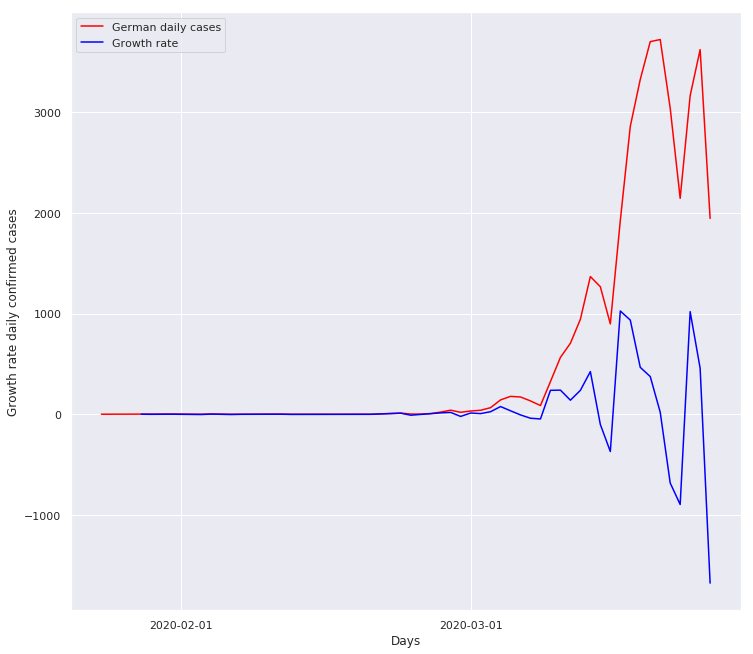

In [41]:
gr_day_reported = df_daily_data.groupby('Meldedatum')

# TODO: make these relative to screen size somehow
figsize = (12,11)
fig = plt.figure(figsize=figsize)
ax = plt.axes()

# set plot stuff
begin_day = df_daily_data['Meldedatum'].iloc[0].strftime('%m-%d')
present_day = df_daily_data['Meldedatum'].iloc[-1].strftime('%m-%d')
days_steps = [t for t in np.arange(10,len(gr_day_reported) - 3, step=10)]
xtick_locations = [0] + days_steps + [len(gr_day_reported) - 1]
xtick_labels = [begin_day] + days_steps + [present_day]

# plt.xticks(xtick_locations, xtick_labels)
# plt.xlabel('Days')
# plt.ylabel('Growth rate daily confirmed cases')

#ax.set_xticks(xtick_locations, xtick_labels)
#ax.set_xticklabels(xtick_labels)
#plt.xticks(xtick_locations, xtick_labels)
ax.set_xlabel('Days')
ax.set_ylabel('Growth rate daily confirmed cases')
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=1))
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%m-%d"))
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))

# Germany
sum_cases_per_day = gr_day_reported['AnzahlFall'].sum()
growth_rate = sum_cases_per_day.diff()

#ax.plot(sum_cases_per_day.reset_index(drop=True), color='r')
ax.plot(sum_cases_per_day, color='red')
#ax.plot(growth_rate.reset_index(drop=True))
ax.plot(growth_rate, color='blue')

ax.legend(['German daily cases', 'Growth rate'])

# plt.plot(sum_cases_per_day.reset_index(drop=True), color='r')
# plt.plot(growth_rate.reset_index(drop=True))

# plt.legend(['German daily cases', 'Growth rate'])

In [15]:
# Get daily cases and growth rate per German state

loc_unknown_col = "-nicht erhoben-"
state_names = df_daily_data['Bundesland'].unique()
# remove column name for unknown location of the case
index = np.where(state_names == loc_unknown_col)
state_names = np.delete(state_names, index)

df_daily_data.groupby(['Meldedatum', 'Bundesland'])
states_daily = df_daily_data.groupby(['Meldedatum', 'Bundesland'])['AnzahlFall'].sum()
df_per_state_daily = pd.DataFrame()
for state in state_names:
    df_per_state_daily[state] = states_daily.unstack()[state].fillna(0)

In [16]:
# TODO: make these relative to screen size somehow
figsize = (15,13)
ax_label_fontsize = 8.0
legend_fontsize = 8.0

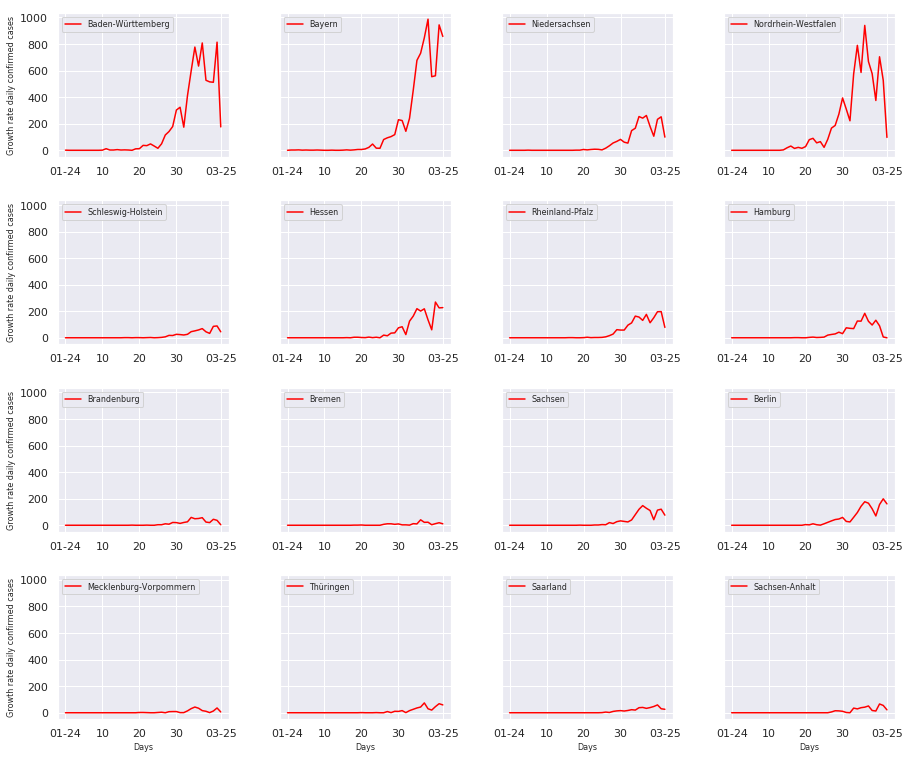

In [17]:
# Plot per German state

fig, ax = plt.subplots(4, 4, sharey=True, figsize=figsize)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for axis in ax.flat:
    axis.set_xticks(xtick_locations)
    axis.set_xticklabels(xtick_labels)

for plt_row in ax:
    plt_row[0].set_ylabel('Growth rate daily confirmed cases', fontsize=ax_label_fontsize)
    
for column_plots in ax.T:
    column_plots[-1].set_xlabel('Days', fontsize=ax_label_fontsize)
    
# ax[0][0].plot(berlin_daily.reset_index(drop=True), '--r')
# ax[0][0].legend(['sum daily cases', 'growth rate', 'Berlin cases'])

ix = 0
for subp in ax.flat:
    state = state_names[ix]
    subp.plot(df_per_state_daily[state].reset_index(drop=True), color='red', label = "{}".format(state))
    subp.legend(fontsize=legend_fontsize, loc="upper left")    
    ix += 1


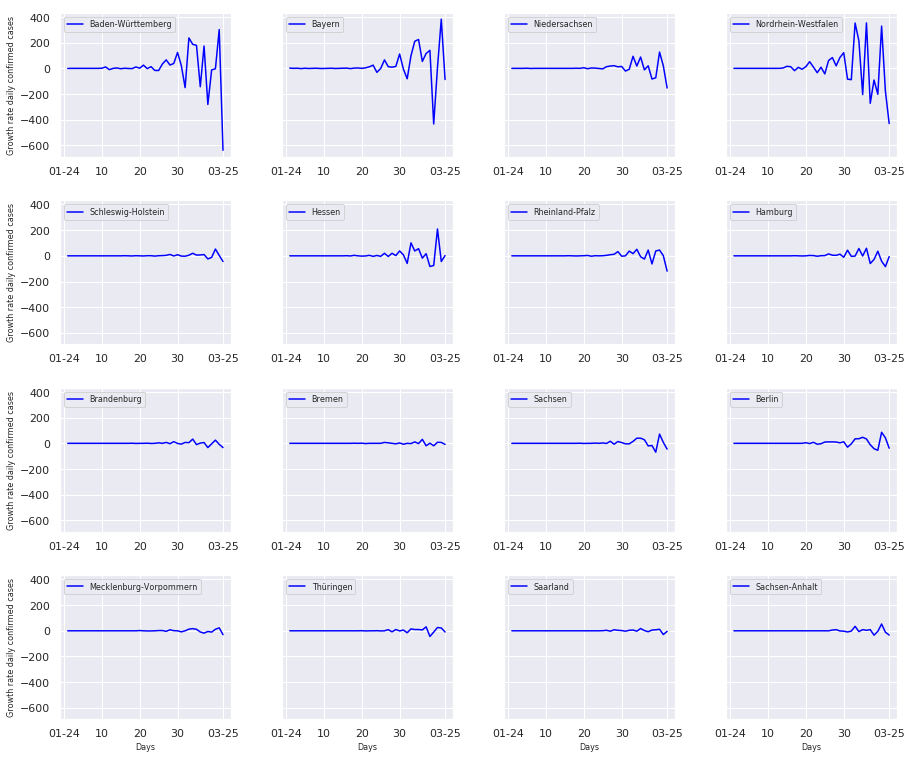

In [18]:
# Plot growth rate of daily confirmed cases per German state

fig, ax = plt.subplots(4, 4, sharey=True, figsize=figsize)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for axis in ax.flat:
    axis.set_xticks(xtick_locations)
    axis.set_xticklabels(xtick_labels)

for plt_row in ax:
    plt_row[0].set_ylabel('Growth rate daily confirmed cases', fontsize=ax_label_fontsize)
    
for column_plots in ax.T:
    column_plots[-1].set_xlabel('Days', fontsize=ax_label_fontsize)
    
# ax[0][0].plot(berlin_daily.reset_index(drop=True), '--r')
# ax[0][0].legend(['sum daily cases', 'growth rate', 'Berlin cases'])

ix = 0
for subp in ax.flat:
    state = state_names[ix]
    subp.plot(df_per_state_daily[state].diff().reset_index(drop=True), color='blue', label = "{}".format(state))
    subp.legend(fontsize=legend_fontsize, loc="upper left")    
    ix += 1